In [95]:
import os
import pandas as pd 
import matplotlib
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns
import itertools as it
from sklearn.multiclass import OneVsRestClassifier

os.chdir('/lustre/home/reynaj/Projects/20241011.Byrd_Lab.IBD_NuLisa')
outdir = 'results/specimen_focused/logit_model/'

os.makedirs(outdir, exist_ok=True)

# set the random_state
random_state = 17

In [96]:
# Load the protein levels data
protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.npq.tsv", sep="\t")
protein_data = protein_data.T

# extract triplet
protein_data = protein_data.loc[:, ['IFNB1', 'FGF23', 'EGF']]

# Load the clinical data
clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")

# remove alamar samples
keep = (~clinical_data['sample_id'].str.contains('SC_Rep')).tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

In [130]:
clinical_data

,project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,original_subject_id,event_name,ibd_diagnosis,date_collection,disease_activity,matched_subject_id,notes,ibd_indicator,disease_activity_indicator
0,Byrd_IBD_Saliva_sup,Saliva,TRP-34082,2023-11-30 15:34:05.854,1.0,A1,1100.0,TRP-34082,1.0,CD,2023-11-30,Quiescent,1.0,NaN,IBD Super Group,In-active Disease
1,Byrd_IBD_Saliva_sup,Saliva,TRP-34086,2023-11-30 15:34:05.854,1.0,A2,1100.0,TRP-34086,1.0,CD,2023-11-30,Quiescent,3.0,NaN,IBD Super Group,In-active Disease
2,Byrd_IBD_Saliva_sup,Saliva,TRP-42335,2023-12-20 16:51:00.779,1.0,A3,1000.0,TRP-42335,1.0,CD,2023-12-20,Quiescent,7.0,NaN,IBD Super Group,In-active Disease
3,Byrd_IBD_Saliva_sup,Saliva,TRP-42324,2023-12-20 13:54:07.467,1.0,A4,1000.0,TRP-42324,1.0,UC,2023-12-20,Quiescent,6.0,NaN,IBD Super Group,In-active Disease
4,Byrd_IBD_Saliva_sup,Saliva,TRP-42322,2023-12-20 13:53:28.319,1.0,A5,1000.0,TRP-42322,1.0,CD,2023-12-20,Quiescent,5.0,NaN,IBD Super Group,In-active Disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Byrd_IBD_Saliva_sup,Saliva,TRP-061-48257-1,2024-06-26 14:38:06.475,1.0,I3,1300.0,TRP-061-48257-1,1.0,Control,2024-06-26,N/A (Non-IBD Control),61.0,NaN,Control Super Group,In-active Disease
82,Byrd_IBD_Saliva_sup,Saliva,TRIANGLE PEDS-042-48265-3,2024-07-03 15:35:31.499,1.0,I4,1100.0,TRIANGLE PEDS-042-48265-3,3.0,UC,2024-07-03,Quiescent,42.0,NaN,IBD Super Group,In-active Disease
83,Byrd_IBD_Saliva_sup,Saliva,TRP-063-48262-3,2024-07-03 15:26:15.056,1.0,I6,1800.0,TRP-063-48262-3,1.0,UC,2024-07-03,Quiescent,63.0,NaN,IBD Super Group,In-active Disease
84,Byrd_IBD_Saliva_sup,Saliva,TRP-064-48267-3,2024-07-10 15:46:29.53,1.0,I7,1800.0,TRP-064-48267-3,1.0,Control,2024-07-10,N/A (Non-IBD Control),64.0,NaN,Control Super Group,In-active Disease


## Predicting IBD Diagnosis

In [97]:
# Extract the diagnosis column
task_data = clinical_data['ibd_diagnosis']

In [98]:
# resample to balance classes
X_resampled, task_resampled = RandomOverSampler(random_state=random_state).fit_resample(protein_data, task_data)

In [99]:
# X_train, y_train = protein_data, diagnosis
#X_train, X_test, y_train, y_test = train_test_split(protein_data, task_data, test_size=0.2, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, task_resampled, test_size=0.2, random_state=random_state)

model = linear_model.LogisticRegression(random_state=0)

In [100]:
# Fit the model on the training data
model.fit(X_train, y_train)

/lustre/home/reynaj/anaconda3/envs/starter/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [101]:
# Check the accuracy on the training data
train_accuracy = model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.2f}")

Training Accuracy: 0.66


In [102]:
# Check the accuracy on the test data
test_accuracy = model.score(X_test, y_test)
print(f"Testing Accuracy: {test_accuracy:.2f}")

Testing Accuracy: 0.58


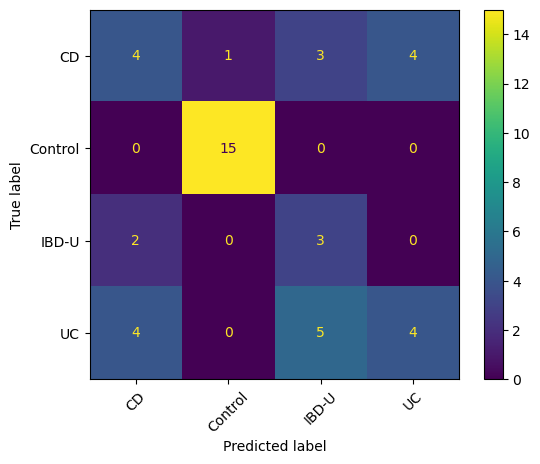

In [103]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

# Rotate x-tick labels
plt.xticks(rotation=45)  # Change the angle as needed (e.g., 90 for vertical)
plt.show()

fn = os.path.join(outdir, 'logit_model.ibd_diagnosis.confusion_matrix.png')
disp.figure_.savefig(fn, dpi=600)

In [104]:
# Print the classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          CD       0.40      0.33      0.36        12
     Control       0.94      1.00      0.97        15
       IBD-U       0.27      0.60      0.38         5
          UC       0.50      0.31      0.38        13

    accuracy                           0.58        45
   macro avg       0.53      0.56      0.52        45
weighted avg       0.59      0.58      0.57        45



### ROC curve analysis

In [105]:
# # Compute the false positive rate and true positive rate
# fpr, tpr, _ = roc_curve(y_test, predictions)
classes = sorted(set(predictions))

In [106]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
n_samples, n_classes = y_onehot_test.shape  # (n_samples, n_classes)
classes = label_binarizer.classes_

target_names = {'IBD-U': 'IBD-U', 'CD': 'CD', 'UC': 'UC', 'Control': 'Control'}

In [107]:
class_of_interest = "UC"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

3

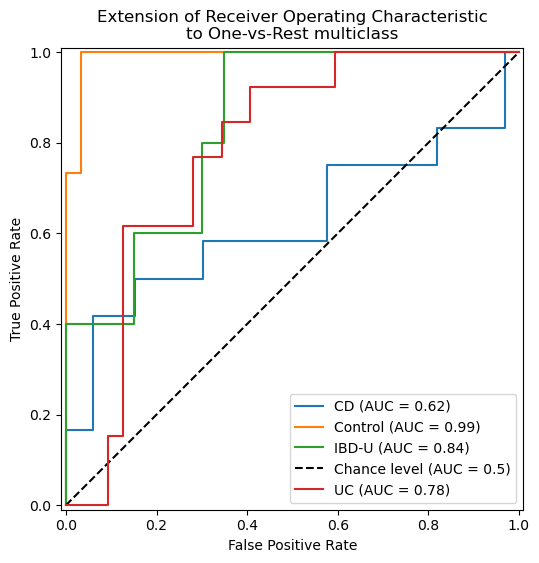

In [108]:
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

y_score = model.predict_proba(X_test)

fig, ax = plt.subplots(figsize=(6, 6))

colors = sns.color_palette() # ycle(["aqua", "darkorange", "cornflowerblue", ])
i = 0
for class_id, (cclass, color) in enumerate(zip(classes, colors)):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{target_names[cclass]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

## Predicting Disease Activity

In [109]:
# Extract the diagnosis column
task_data = clinical_data['disease_activity']

In [110]:
task_data

0                 Quiescent
1                 Quiescent
2                 Quiescent
3                 Quiescent
4                 Quiescent
              ...          
81    N/A (Non-IBD Control)
82                Quiescent
83                Quiescent
84    N/A (Non-IBD Control)
85    N/A (Non-IBD Control)
Name: disease_activity, Length: 86, dtype: object

In [111]:
# resample to balance classes
X_resampled, task_resampled = RandomOverSampler(random_state=random_state).fit_resample(protein_data, task_data)

In [112]:
task_resampled.value_counts()

disease_activity
Quiescent                62
Moderate                 62
Mild                     62
N/A (Non-IBD Control)    62
Name: count, dtype: int64

In [113]:
#X_train, X_test, y_train, y_test = train_test_split(protein_data, task_data, test_size=0.2, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, task_resampled, test_size=0.2, random_state=random_state)
model = linear_model.LogisticRegression(random_state=0)

In [114]:
# Fit the model on the training data
model.fit(X_train, y_train)

/lustre/home/reynaj/anaconda3/envs/starter/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [115]:
# Check the accuracy on the training data
train_accuracy = model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.2f}")

Training Accuracy: 0.59


In [116]:
# Check the accuracy on the test data
test_accuracy = model.score(X_test, y_test)
print(f"Testing Accuracy: {test_accuracy:.2f}")

Testing Accuracy: 0.62


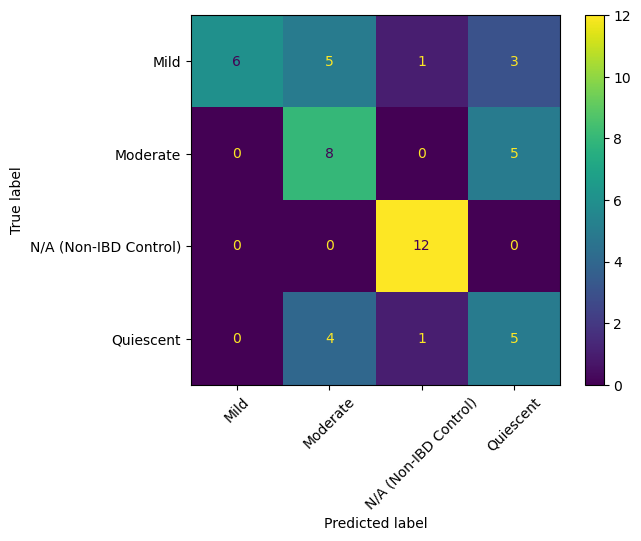

In [117]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

# Rotate x-tick labels
plt.xticks(rotation=45)  # Change the angle as needed (e.g., 90 for vertical)
plt.show()

fn = os.path.join(outdir, 'rf_model.disease_activity.confusion_matrix.png')
disp.figure_.savefig(fn, dpi=600)

In [118]:
# Print the classification report
print(classification_report(y_test, predictions))

                       precision    recall  f1-score   support

                 Mild       1.00      0.40      0.57        15
             Moderate       0.47      0.62      0.53        13
N/A (Non-IBD Control)       0.86      1.00      0.92        12
            Quiescent       0.38      0.50      0.43        10

             accuracy                           0.62        50
            macro avg       0.68      0.63      0.62        50
         weighted avg       0.70      0.62      0.62        50



In [119]:
# # get importance scores
# importances = model.feature_importances_
# feature_names = model.feature_names_in_

# # get data
# topn = 10
# indices = np.argsort(importances)[::-1][0:topn]
# feature_names = protein_data.columns

In [120]:
# # plot
# fig, ax = plt.subplots()
# ax.set_title("Feature Importances")
# ax.bar(range(topn), importances[indices], align="center")
# ax.set_xticks(range(topn), np.array(feature_names)[indices], rotation=90)
# ax.set_xlim([-1, topn])

# fn = os.path.join(outdir, 'logit_model.disease_activity.feature_importance.png')
# fig.savefig(fn, dpi=600)

In [121]:
# importances_df = pd.DataFrame([importances, feature_names]).T
# importances_df.columns = ['score', 'protein']
# importances_df = importances_df[['protein', 'score']]

In [122]:
# outfn = os.path.join(outdir, 'logit_model.disease_activity.scores.tsv')
# importances_df.to_csv(outfn, index=None, sep="\t")

In [123]:
# importances_df.head(20)

### Bootstrap Analysis

In [124]:
# bs_data = []
# num_seeds = 100

# for seed in range(num_seeds):

#     model = RandomForestClassifier(random_state=seed)

#     # Fit the model on the training data
#     model.fit(X_train, y_train)

#     # Check the accuracy on the training data
#     train_accuracy = model.score(X_train, y_train)

#     # Check the accuracy on the test data
#     test_accuracy = model.score(X_test, y_test)

#     # get importance scores
#     importances = model.feature_importances_

#     # get data
#     topn = 10
#     indices = np.argsort(importances)[::-1][0:topn]
#     topn_feature_names = np.array(protein_data.columns)[indices]

#     cdata = [seed, train_accuracy, test_accuracy, topn_feature_names]
#     bs_data.append(cdata)

In [125]:
# # load data into df
# bs_df = pd.DataFrame(bs_data)
# bs_df.columns = ['seed', 'train_acc', 'test_acc', 'top_genes']

# # value counts for the top genes
# dist_data = list(it.chain(*bs_df.top_genes.tolist()))
# dist_df = pd.Series(dist_data).value_counts().to_frame().reset_index()
# dist_df.rename(columns={'index': 'top_gene'}, inplace=True)
# dist_df.loc[:, 'pct'] = dist_df.loc[:, 'count'] / num_seeds * 100

In [126]:
# dist_df

In [127]:
# fig, ax = plt.subplots(figsize=(8,6))

# sns.barplot(dist_df.iloc[0:20], y='top_gene', x='pct')

# ax.set_title(f'Bootstrap frequency of a given gene in {num_seeds} RF models')
# ax.set_ylabel(f'Genes (those present in the top {topn})')
# ax.set_xlabel('Percent')

In [128]:
# outfn = os.path.join(outdir, 'bootstrap_results.da.tsv')
# dist_df.to_csv(outfn, sep='\t', index=False, header=True)